In [19]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# 1 Read in data

In [20]:
gold = pd.read_csv('C:\\Users\\cherr\\Desktop\\UT Austin\\Summer Courses\\Python\\gold.txt',dtype = unicode, delimiter= '\t', header = None, names=['url','category'])
labels = pd.read_csv('C:\\Users\\cherr\\Desktop\\UT Austin\\Summer Courses\\Python\\labels.txt',dtype = unicode, delimiter= '\t', header = None, names=['turk','url','category'])
labels.drop_duplicates(inplace = True)

# 2 Split into two DataFrames

In [21]:
labels_on_gold =labels[labels['url'].isin(gold['url'])] #Select all the urls which are present in gold
labels_unknown = labels[~labels.isin(labels_on_gold)].dropna() # Select all the urls which are not present in gold
print(labels_unknown.shape)
print(labels_on_gold.shape)
print(labels.shape)



(86629, 3)
(3319, 3)
(89948, 3)


# 3 Compute accuracies of turks

In [22]:
df1 = labels.merge(gold, left_on = 'url', right_on = 'url', suffixes = ['_turks','_gold']) # Merge label with gold dataframe
df1['Match'] = np.where(df1['category_turks'] == df1['category_gold'], 1,0) # 1 if turks category is same in both labels and gold dataframe
df2 = df1.groupby('turk')[['url']].count() # Count number of urls that a turk has rated
df3 = df1.groupby('turk')[['Match']].mean() # Average the number of times turk rating in label and gold was same
raters_goodness = df2.merge(df3,left_on = 'turk', right_on = 'turk')
raters_goodness.columns = ['NoOfRatings', 'AverageCorrectness']
raters_goodness.head()

,NoOfRatings,AverageCorrectness
turk,,
A112DVP1KG4QZU,1,1.000000
A1253FXHCZ9CWM,29,0.517241
A12CY1Q7XKJJDE,1,1.000000
A12RE8G66WTO8B,20,0.750000
A12Y1GTGIQDGRA,3,0.333333


# 4 Odds ratios

In [23]:
raters_goodness['Odds'] = raters_goodness['AverageCorrectness'] / (1.001 - raters_goodness['AverageCorrectness'])
raters_goodness.head()

,NoOfRatings,AverageCorrectness,Odds
turk,,,
A112DVP1KG4QZU,1,1.000000,1000.000000
A1253FXHCZ9CWM,29,0.517241,1.069214
A12CY1Q7XKJJDE,1,1.000000,1000.000000
A12RE8G66WTO8B,20,0.750000,2.988048
A12Y1GTGIQDGRA,3,0.333333,0.499251


# 5 Most accurate turks

In [24]:
# Filter turks who have rated atleast 20 gold urls and display the top 10 based on their accuracy
raters_goodness[raters_goodness['NoOfRatings'] > 19].sort_values(by = 'AverageCorrectness', ascending = False)[:10]

,NoOfRatings,AverageCorrectness,Odds
turk,,,
A2U0R4X38GUKZE,20,0.950000,18.627451
A22C0PJUBFJTI0,36,0.916667,10.869565
A23YQUBXZPKILZ,24,0.875000,6.944444
ATVALOQVDCMZW,103,0.854369,5.826657
A1HIXWH4OXT8S4,40,0.825000,4.687500
A3220HG1O83HQ4,22,0.818182,4.475385
A32W20KGQXS0LL,25,0.800000,3.980100
A20PWAB7G3HDHU,20,0.800000,3.980100
AJSJVK40F5HM6,28,0.785714,3.649635


# 6 Rating counts versus accuracy

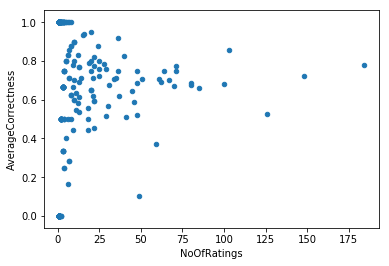

In [25]:
raters_goodness.plot('NoOfRatings','AverageCorrectness', kind = 'scatter')

In [ ]:
# Since it is not a linear curve, it clearly depicts that the accuracy(average correctness of a turk) does not increase with 
#the increase in the number of urls that he has rated. As we can see, majority of turks have rated 0- 50 0r 75 urls and have 
#pretty high rating

# 7 Overall predicted odds

In [46]:
#Filter out top gold url turks falling in top 25 quantile
top25 = raters_goodness[raters_goodness['NoOfRatings'] > raters_goodness['NoOfRatings'].quantile(0.75)]
top25.reset_index(inplace = True)
new_df = labels_unknown.merge(top25, left_on = 'turk', right_on = 'turk')
# Calculate product of the odds of all turks for particular url and category
new_df1 = new_df.groupby(['url','category'])[['Odds']].prod()
new_df1.reset_index(inplace = True)
new_df1.columns = ['url','category','OverallOdds']
new_df1.head()
#Creating a dataframe(cartesian product) of all the urls and possible categories
b = pd.DataFrame(['P', 'G', 'R', 'X'])
cross_table = pd.MultiIndex.from_product([np.unique(new_df1['url']), b[0]], names = ["a", "b"])
cross_table = pd.DataFrame(index = cross_table).reset_index()
overall_odds = cross_table.merge(new_df1,how = 'left', left_on = ['a','b'], right_on = ['url', 'category'])

overall_odds.drop(['url', 'category'], inplace=True, axis=1)
overall_odds.rename(columns={'a':'url', 'b':'category'}, inplace=True)
overall_odds.head(10)

,url,category,OverallOdds
0,http://0-101.net,P,NaN
1,http://0-101.net,G,2.297602
2,http://0-101.net,R,NaN
3,http://0-101.net,X,NaN
4,http://000.cc,P,NaN
5,http://000.cc,G,1.485456
6,http://000.cc,R,NaN
7,http://000.cc,X,NaN
8,http://0000.jp,P,NaN
9,http://0000.jp,G,14.339248


# 8 Predicted categories

In [53]:
# Calculate max odd value for each url and category
result1 = new_df1.groupby('url')[['OverallOdds']].max()
result1.reset_index()
result_75 = result1.merge(new_df1, left_on = ['url','OverallOdds'], right_on = ['url','OverallOdds'])
result_75.drop_duplicates('url',inplace = True)
result_75.head()

,url,OverallOdds,category
0,http://0-101.net,2.297602,G
1,http://000.cc,1.485456,G
2,http://0000.jp,14.339248,G
3,http://000relationships.com,3.841962,G
4,http://000vitamins.com,4.033641,G


# 9 Predicted categories using more turks

In [54]:
# Filter the gold url turks in top 75 quantile
top75 = raters_goodness[raters_goodness['NoOfRatings'] > raters_goodness['NoOfRatings'].quantile(0.25)]
top75.reset_index(inplace = True)

# Calculate product of odds of all the turks for a particular url and category
new_df_75 = labels_unknown.merge(top75, left_on = 'turk', right_on = 'turk')
new_df2 = new_df_75.groupby(['url','category'])[['Odds']].prod()
new_df2.reset_index(inplace = True)

# Keep maximum odd against each urla nd category
new_df2.columns = ['url','category','OverallOdds']
result2 = new_df2.groupby('url')[['OverallOdds']].max()
result2.reset_index()
result_25 = result2.merge(new_df2, left_on = ['url','OverallOdds'], right_on = ['url','OverallOdds'])
result_25.drop_duplicates('url',inplace = True)

#Merge the result_25 and result_75 dataframes
final_df = result_25.merge(result_75,left_on = 'url', right_on = 'url',suffixes = ['_25','_75'])

#Do a crosstab on the categories obatined from result_25 and result_75 and count the urls for each
pd.crosstab(index = final_df['category_25'], columns = final_df['category_75'], values = final_df['url'], aggfunc = 'count')

category_75,G,P,R,X
category_25,,,,
G,8280,196,22,28
P,586,352,34,5
R,180,52,127,28
X,214,25,25,456


In [ ]:
# Most of the errors can be seen in category_75 = G and category_25 = P; errors = 586 (urls where the category mismatched). 
#And even if we see at overall level, most of the errors are in category P

In [219]:
result_25['url'].drop_duplicates().shape

(10700L,)

In [220]:
result_25.drop_duplicates().shape

(10709, 3)

In [23]:
df = labels.merge(gold,left_on ='url', right_on = 'url')
df.shape

(3324, 4)